In [8]:
%load_ext autoreload
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torchvision.datasets import MNIST, CIFAR10 
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn.model_selection import StratifiedShuffleSplit

%autoreload 2
from networks import *
from utils import *
from losses import *

import matplotlib.pyplot as plt
import progressbar
import random

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Set seed, clear cache and enable anomaly detection (for debugging)
set_seed(42)
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)


# Set training static parameters and hyperparameters
nepochs=50
dims_latent = 10                            
learning_rate=1e-3
batch_size=32                                        
device=set_device("cuda", 0)
train_transform = Compose([
    Resize(28),
    ToTensor(),
])
train_size=0.1

Cuda installed! Running on GPU 0 GeForce RTX 2080 Ti!


# MNIST Example

In [3]:
# Datasets and dataloaders
ds = MNIST("./", download=False, train=True, transform=train_transform)
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=1-train_size, random_state=42).split(ds.data, ds.targets)
train_idx, valid_idx = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

X_train, y_train = ds.data[train_idx] / 255., ds.targets[train_idx]
trainds = TensorDataset(X_train.unsqueeze(1).float(), y_train.float())

trainds = Subset(ds, [0])

idx_5 = []
for i in range(len(ds)):
    if ds[i][1] == 5:
        idx_5.append(i)
        if len(idx_5) == 10:
            break
trainds = Subset(ds, idx_5)

train_loader = DataLoader(trainds, batch_size=batch_size, shuffle=True, num_workers=4)

X = trainds[0][0].unsqueeze(0).to(device) # a sample for check ups
print("Trainable Images:", len(trainds))
print(X.shape, X.min().item(), X.max().item())



Trainable Images: 10
torch.Size([1, 1, 28, 28]) 0.0 1.0


## Autoencoder

In [9]:
# Model and optimisers
model = Autoencoder(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X).shape)

# Losses
l2loss    = nn.MSELoss(reduction="sum")
awi1D     = AWLoss1D(reduction="sum", std=1e-4, return_filters=False)
awi1D_val = AWLoss1D(reduction="sum", std=1e-4, return_filters=True)
switch_at_epoch = 0 # swtich from pure l2 to total loss, set to 0 to disable, set to nepochs to run purely mse   


# Training loop
print("\n\nTraining started ...")
with progressbar.ProgressBar(max_value=nepochs*3) as bar:    
    for epoch in range(nepochs*3):
        if epoch < switch_at_epoch:
            epoch_loss, epoch_mse = train_ae(model, train_loader, optimizer, l2loss, device=device)
        else:
            epoch_loss, epoch_mse = train_ae(model, train_loader, optimizer, awi1D, device=device)
        bar.update(epoch)
            

        # Metric logs and plots
        log = {"epoch": epoch, "train_mse_loss":epoch_mse.item(), "train_awi1d_loss": epoch_loss.item()}
        if epoch % 10 == 0 or epoch==nepochs-1:
            idx = random.randint(0, len(trainds))
            idx=-1
            X = trainds[idx][0].unsqueeze(0).to(device)
            recon = model(X)
            
            _, v, T = awi1D_val(recon, X)
            v = v[0]

            print("\n", log)
            print(" argidx T, v: ",torch.argmin(T).item(), torch.argmax(torch.abs(v)).item())

            plot_grad_flow(model.named_parameters())

            fig, axs = plt.subplots(2,3)
            axs[0, 0].imshow(recon[0, 0].cpu().detach().numpy(), cmap="gray")
            axs[0, 0].set_title("recon")

            axs[0, 1].imshow(X[0, 0].cpu().detach().numpy(), cmap="gray")
            axs[0, 1].set_title("orig")

            axs[0, 2].imshow(X[0, 0].cpu().detach().numpy() - recon[0, 0].cpu().detach().numpy())
            axs[0, 2].set_title("diff")

            axs[1, 0].plot(T.flatten().detach().cpu().numpy())
            axs[1, 0].plot(v.detach().cpu().numpy())
            axs[1, 0].set_title("T-1D vs v-1D")

            axs[1, 1].plot((T.flatten()*v).detach().cpu().numpy())
            axs[1, 1].set_title("T1D * v1D")

            plt.show()


torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


Training started ...



KeyboardInterrupt: 

## Variational Autoencoder

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


Training started ...
N/A% (0 of 50) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 {'epoch': 0, 'train_mse': 0.23472262918949127, 'train_loss': 4.996134281158447, 'train_kl_loss': 51.66291809082031}
 argidx T, v:  391 665


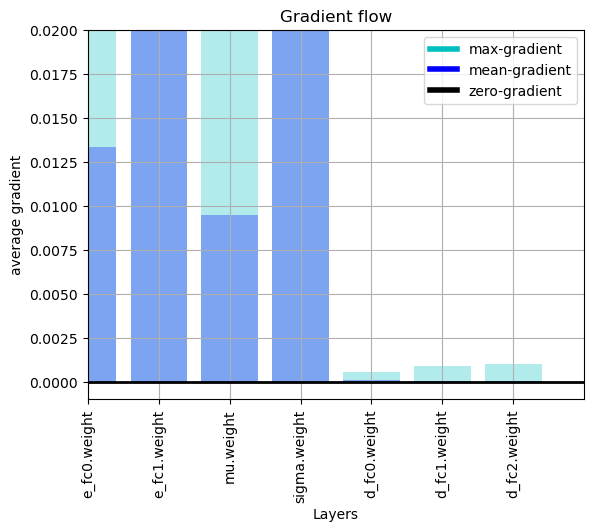

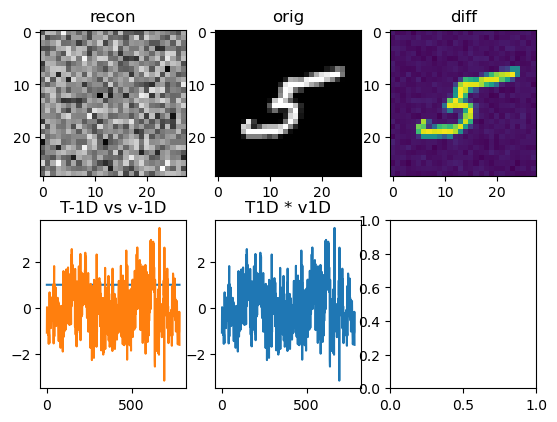

 20% (10 of 50) |####                    | Elapsed Time: 0:00:15 ETA:   0:00:56
 {'epoch': 10, 'train_mse': 0.2354072779417038, 'train_loss': 4.9006266593933105, 'train_kl_loss': 36.02338790893555}
 argidx T, v:  391 391


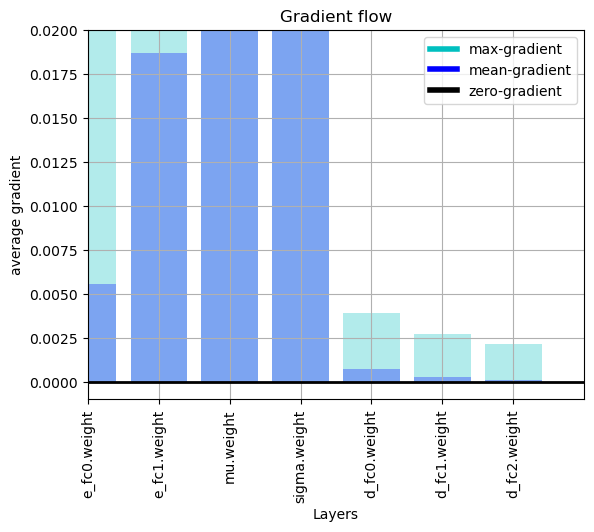

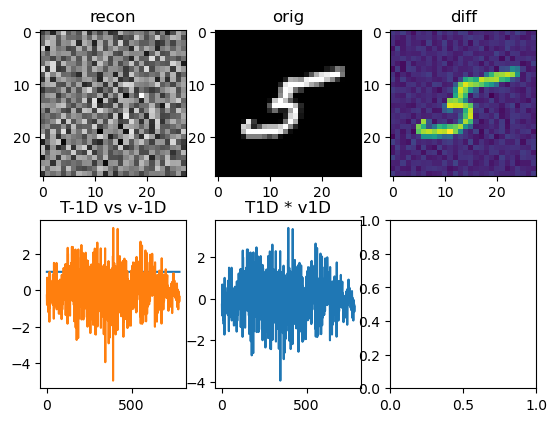

 40% (20 of 50) |#########               | Elapsed Time: 0:00:30 ETA:   0:00:41
 {'epoch': 20, 'train_mse': 0.24248360097408295, 'train_loss': 4.833458423614502, 'train_kl_loss': 34.80610656738281}
 argidx T, v:  391 391


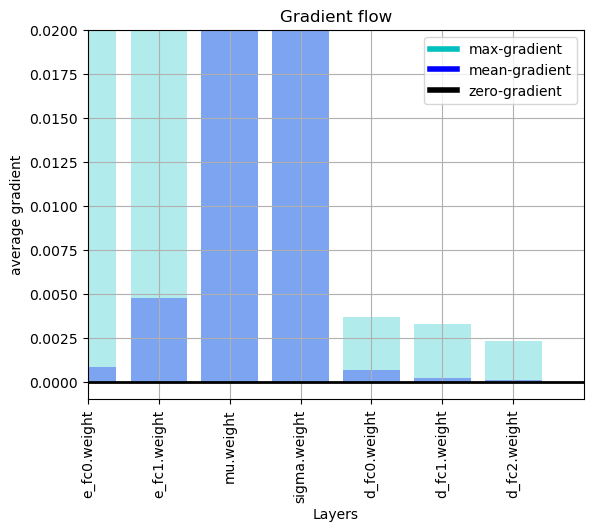

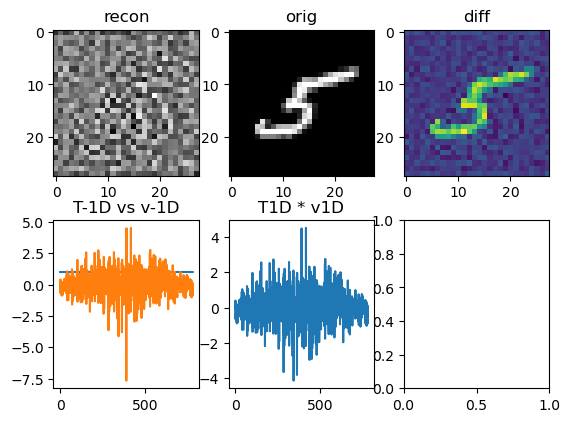

 60% (30 of 50) |##############          | Elapsed Time: 0:00:46 ETA:   0:00:26
 {'epoch': 30, 'train_mse': 0.2506844997406006, 'train_loss': 4.728940010070801, 'train_kl_loss': 34.721092224121094}
 argidx T, v:  391 391


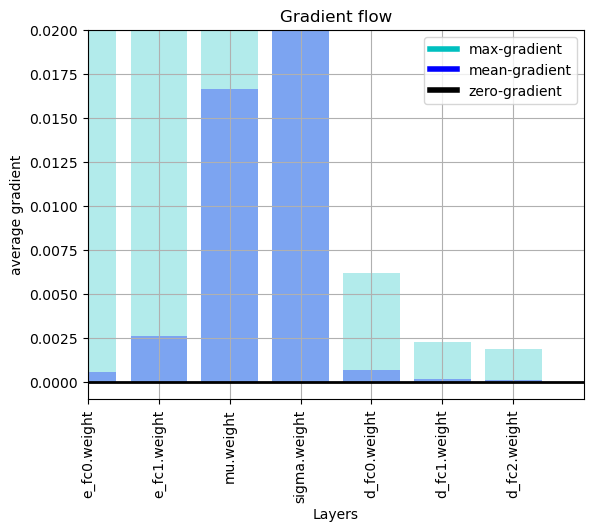

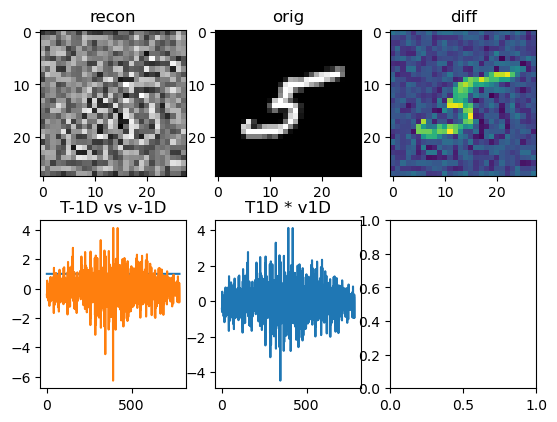

 80% (40 of 50) |###################     | Elapsed Time: 0:00:59 ETA:   0:00:11
 {'epoch': 40, 'train_mse': 0.2581224739551544, 'train_loss': 4.683350086212158, 'train_kl_loss': 34.70663833618164}
 argidx T, v:  391 391


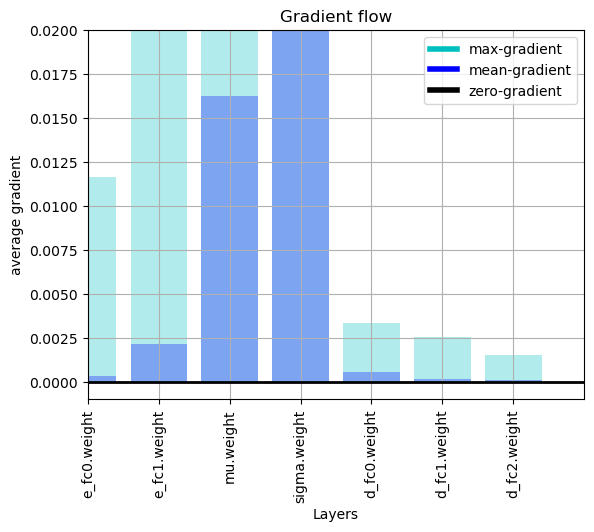

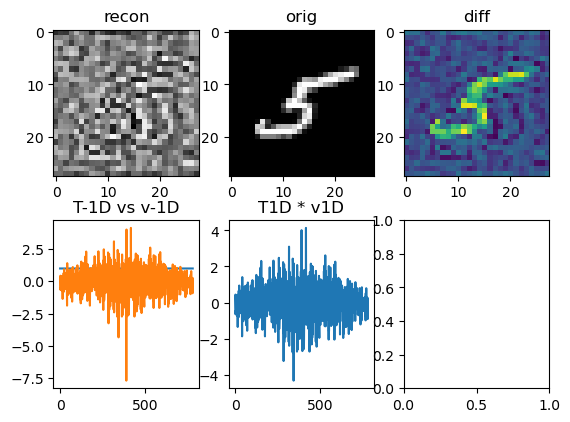

 98% (49 of 50) |####################### | Elapsed Time: 0:01:12 ETA:   0:00:01
 {'epoch': 49, 'train_mse': 0.26487213373184204, 'train_loss': 4.717624187469482, 'train_kl_loss': 34.6729736328125}
 argidx T, v:  391 391


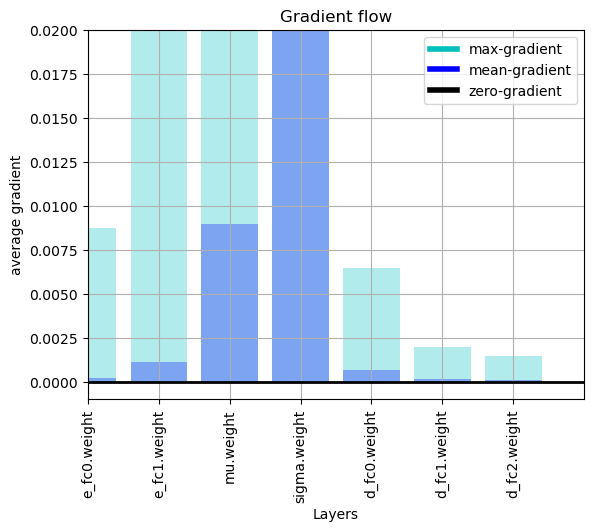

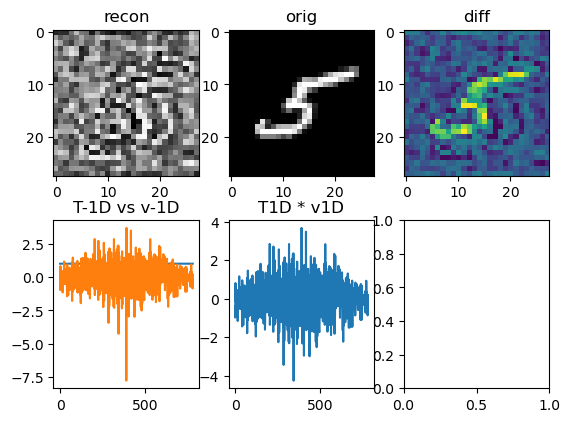

100% (50 of 50) |########################| Elapsed Time: 0:01:13 Time:  0:01:13


In [5]:
# Model and optimisers
model = VAE(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X)[0].shape)

# Losses
l2loss    = nn.MSELoss(reduction="sum")
awi1D     = AWLoss1D(reduction="sum", std=1e-4, return_filters=False)
awi1D_val = AWLoss1D(reduction="sum", std=1e-4, return_filters=True)
switch_at_epoch = 0 # swtich from mse + kl to awi+kl loss, set to 0 to disable, set to nepochs to run purely mse   


# Training loop
print("\n\nTraining started ...")
with progressbar.ProgressBar(max_value=nepochs) as bar:    
    for epoch in range(nepochs):
        if epoch < switch_at_epoch:
            epoch_loss, epoch_mse, epoch_kl = train_vae(model, train_loader, optimizer, l2loss, device=device)
        else:
            epoch_loss, epoch_mse, epoch_kl = train_vae(model, train_loader, optimizer, awi1D, device=device)
        bar.update(epoch)
            

        # Metric logs and plots
        log = {"epoch": epoch, "train_mse":epoch_mse.item(), "train_loss": epoch_loss.item(), "train_kl_loss": epoch_kl.item()}
        if epoch % 10 == 0 or epoch==nepochs-1:
            idx = random.randint(0, len(trainds))
            idx=-1
            X = trainds[idx][0].unsqueeze(0).to(device)
            recon, _, _ = model(X)
            _, v, T = awi1D_val(recon, X)
            v = v[0]

            print("\n", log)
            print(" argidx T, v: ",torch.argmin(T).item(), torch.argmax(torch.abs(v)).item())

            plot_grad_flow(model.named_parameters())


            fig, axs = plt.subplots(2,3)
            axs[0, 0].imshow(recon[0, 0].cpu().detach().numpy(), cmap="gray")
            axs[0, 0].set_title("recon")

            axs[0, 1].imshow(X[0, 0].cpu().detach().numpy(), cmap="gray")
            axs[0, 1].set_title("orig")

            axs[0, 2].imshow(X[0, 0].cpu().detach().numpy() - recon[0, 0].cpu().detach().numpy())
            axs[0, 2].set_title("diff")

            axs[1, 0].plot(T.flatten().detach().cpu().numpy())
            axs[1, 0].plot(v.detach().cpu().numpy())
            axs[1, 0].set_title("T-1D vs v-1D")

            axs[1, 1].plot((T.flatten()*v).detach().cpu().numpy())
            axs[1, 1].set_title("T1D * v1D")

            plt.show()
